In [1]:
import tensorflow as tf
from tensorflow import keras
print("Number of GPUS : ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Number of GPUS :  1


True

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from tqdm import tqdm
import glob
import cv2
from keras.layers import Conv2D, Dropout

In [3]:
vgg = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

In [4]:
for layer in vgg.layers:
    layer.trainable = False

In [5]:
x = Flatten()(vgg.output)

In [6]:
folders = glob.glob('smote_data/*')

In [7]:
print(len(folders))

2


In [8]:
model = Sequential()

for layer in vgg.layers:
    model.add(layer)
    

model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='additional_layer') )
model.add(Flatten())
model.add(Dense(2, activation='softmax', name='predictions'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [10]:
optimizer = keras.optimizers.Adam(lr=0.000001)

c:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_path = 'smote_data'
test_path = '../dataset/chest_xray/test'

In [14]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 7750 images belonging to 2 classes.


In [15]:
training_set.class_indices

{'normal': 0, 'pneumonia': 1}

In [16]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [17]:
r = model.fit(training_set,validation_data=test_set,epochs=100,steps_per_epoch=len(training_set),validation_steps=len(test_set))

Epoch 1/100
243/243 [==============================] - 224s 883ms/step - loss: 0.7620 - accuracy: 0.4850 - val_loss: 0.6730 - val_accuracy: 0.6218
Epoch 2/100
243/243 [==============================] - 113s 464ms/step - loss: 0.7130 - accuracy: 0.5239 - val_loss: 0.6633 - val_accuracy: 0.6362
Epoch 3/100
243/243 [==============================] - 116s 475ms/step - loss: 0.6797 - accuracy: 0.5757 - val_loss: 0.6468 - val_accuracy: 0.6763
Epoch 4/100
243/243 [==============================] - 112s 462ms/step - loss: 0.6565 - accuracy: 0.6070 - val_loss: 0.6292 - val_accuracy: 0.7340
Epoch 5/100
243/243 [==============================] - 116s 477ms/step - loss: 0.6402 - accuracy: 0.6404 - val_loss: 0.6096 - val_accuracy: 0.7676
Epoch 6/100
243/243 [==============================] - 111s 458ms/step - loss: 0.6157 - accuracy: 0.6688 - val_loss: 0.5917 - val_accuracy: 0.7965
Epoch 7/100
243/243 [==============================] - 108s 442ms/step - loss: 0.5928 - accuracy: 0.7061 - val_loss: 0

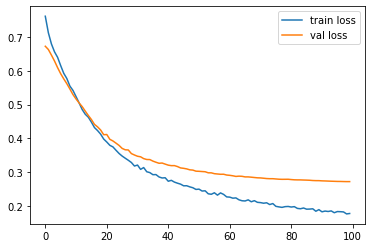

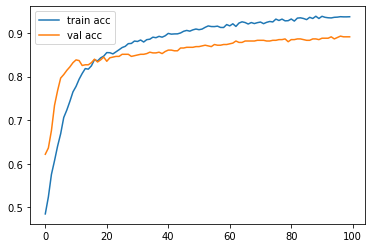

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']